In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

# Inferential Modeling Workflow

This dataset was downloaded from [Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who) and reflects data collected by the WHO about life expectancy and potentially-related factors.  The information is aggregated on a per-country per-year basis.

The following questions have been posed:

1. Does various predicting factors which has been chosen initially really affect the Life expectancy? What are the predicting variables actually affecting the life expectancy?
2. Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
3. How does Infant and Adult mortality rates affect life expectancy?
4. Does Life Expectancy has positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
5. What is the impact of schooling on the lifespan of humans?
6. Does Life Expectancy have positive or negative relationship with drinking alcohol?
7. Do densely populated countries tend to have lower life expectancy?
8. What is the impact of Immunization coverage on life Expectancy?

### Importing the Data

In [3]:
df = pd.read_csv("data/life_expectancy.csv")

In [4]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [ ]:
df.columns

### Initial Data Preparation

The original column names have extra spaces and other irregularities.  Let's clean those up, and also move the target variable to be the first column, for readability

In [6]:
# rename so everything is snake_case
df = df.rename(columns={
    'Life expectancy ': 'Life_Expectancy',
    'Adult Mortality': 'Adult_Mortality',
    'infant deaths': 'Infant_Deaths',
    'percentage expenditure': 'Percentage_Expenditure',
    'Hepatitis B': 'Hepatitis_B',
    'Measles ': 'Measles',
    ' BMI ': 'BMI',
    'under-five deaths ': 'Under_five_Deaths',
    'Total expenditure': 'Total_Expenditure',
    'Diphtheria ': 'Diptheria',
    ' HIV/AIDS': 'HIV_AIDS',
    ' thinness  1-19 years': 'Thinness_1_19_years',
    ' thinness 5-9 years': 'Thinness_5_9_years',
    'Income composition of resources': 'Income_Composition_of_Resources'
})

In [7]:
df.head()

,Country,Year,Status,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,...,Polio,Total_Expenditure,Diptheria,HIV_AIDS,GDP,Population,Thinness_1_19_years,Thinness_5_9_years,Income_Composition_of_Resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [8]:
df.columns

Index(['Country', 'Year', 'Status', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'Under_five_Deaths', 'Polio', 'Total_Expenditure',
       'Diptheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1_19_years',
       'Thinness_5_9_years', 'Income_Composition_of_Resources', 'Schooling'],
      dtype='object')

In [9]:
# reorder so life expectancy is the first column
cols = list(df.columns)
cols = [cols[3]] + cols[:3] + cols[4:]
df = df[cols]

In [10]:
df.head()

,Life_Expectancy,Country,Year,Status,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,...,Polio,Total_Expenditure,Diptheria,HIV_AIDS,GDP,Population,Thinness_1_19_years,Thinness_5_9_years,Income_Composition_of_Resources,Schooling
0,65.0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Data Understanding

There are a lot of variables here!  Let's look at a correlation matrix to see which ones might be the most useful.  (Here we are looking for variables that are highly correlated with the target variable, but not highly correlated with other input variables)

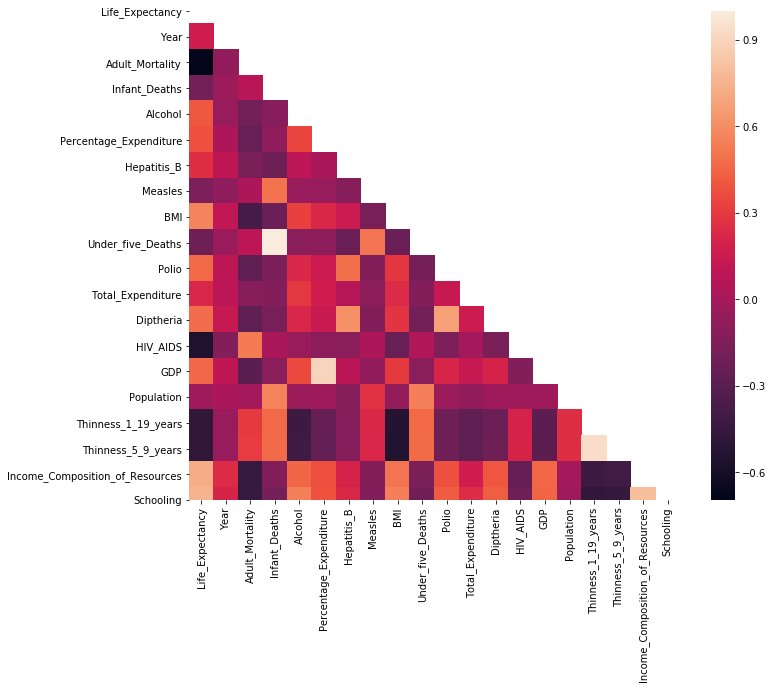

In [11]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1)

Ok, it looks like there are only a few that are highly positively correlated with life expectancy.  Let's make a pair plot of those.

(Note: we don't want to do a pair plot right from the outset because it would be too slow)

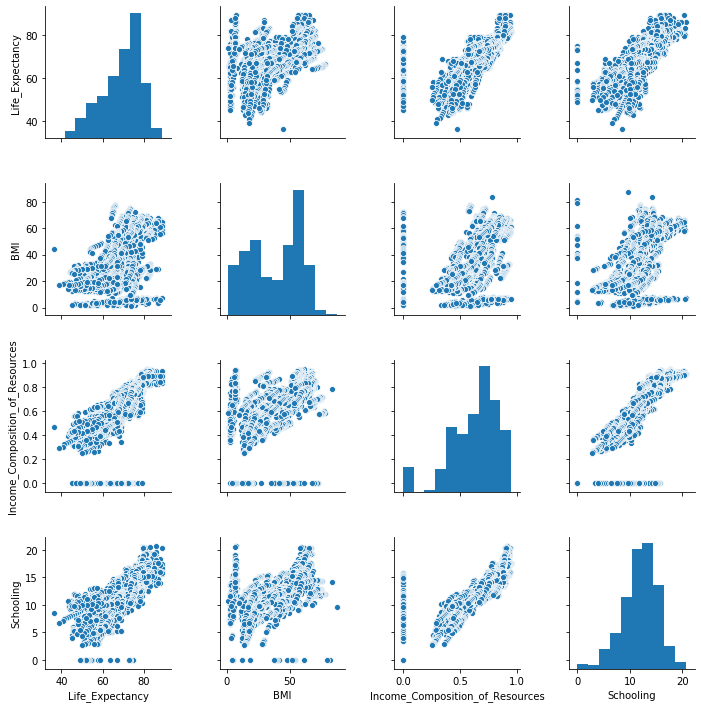

In [12]:
positively_correlated_cols = ['Life_Expectancy','BMI', 'Income_Composition_of_Resources', 'Schooling']
positively_correlated_df = df[positively_correlated_cols]
sns.pairplot(positively_correlated_df);

### First Simple Model

Ok, it looks like the correlation with BMI is a little fuzzier than the others, so let's exclude it for now.  `Schooling` and `Income_Composition_of_Resources` are highly correlated with both life expectancy and each other, so let's only include one of them.  `Schooling` seems like a good choice because it would allow us to answer Question 5.

In [12]:
fsm_df = df[["Schooling", "Life_Expectancy"]].copy()
fsm_df.dropna(inplace=True)

In [13]:
# recommended to use OLS method for multiple independent variables
fsm = ols(formula="Life_Expectancy ~ Schooling", data=fsm_df).fit()

In [14]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     3599.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        20:03:15   Log-Likelihood:                -8964.3
No. Observations:                2768   AIC:                         1.793e+04
Df Residuals:                    2766   BIC:                         1.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.1089      0.437    100.992      0.000      43.252      44.965
Schooling      2.1035      0.035     59.995      0.000       2.035       2.172
==============================================================================
Omnibus:                      283.391   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.013
Skew:                          -0.445   Prob(JB):                    2.28e-244
Kurtosis:                       5.989   Cond. No.                         46.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Evaluation

Not too bad.  We are only explaining about 57% of the variance in life expectancy, but we only have one feature so far and it's statistically significant at an alpha of 0.05.

We could stop right now and say that according to our model:

 - A country with zero years of schooling on average is expected to have a life expectancy of 44.1 years
 - For each additional average year of schooling, we expect life expectancy to increase by 2.1 years

But before we move forward, let's also check for the assumptions of linear regression

#### Linearity

Linear regression assumes that the input variable linearly predicts the output variable.  We already qualitatively checked that with a scatter plot.  But I also think it's a good idea to use a statistical test.  This one is the [Rainbow test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) which is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_rainbow.html#statsmodels.stats.diagnostic.linear_rainbow)

In [15]:
rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.2910159786411675
Rainbow p-value: 1.057579656507341e-06


The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a low p-value means that the current model violates the linearity assumption.

#### Normality

Linear regression assumes that the residuals are normally distributed.  It is possible to check this qualitatively with a Q-Q plot, but this example shows how to assess it statistically.

The [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) test is performed automatically as part of the model summary output, labeled **Jarque-Bera (JB)** and **Prob(JB)**.

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  Thus returning a low p-value means that the current model violates the normality assumption.

#### Homoscadasticity

Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s).  We can visualize this by looking at the predicted life expectancy vs. the residuals.

In [16]:
y = fsm_df["Life_Expectancy"]
y_hat = fsm.predict()
y

0       65.0
1       59.9
2       59.9
3       59.5
4       59.2
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: Life_Expectancy, Length: 2768, dtype: float64

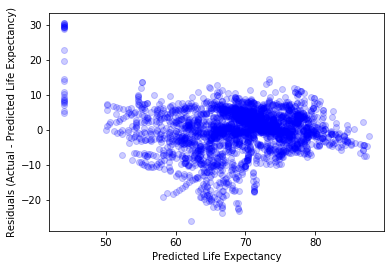

In [20]:
fig2, ax2 = plt.subplots()
ax2.set(xlabel="Predicted Life Expectancy",
        ylabel="Residuals (Actual - Predicted Life Expectancy)")
ax2.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)

Just visually inspecting this, it seems like our model over-predicts life expectancy between 60 and 70 years old in a way that doesn't happen for other age groups.  Plus we have some weird-looking data in the lower end that we might want to inspect.  Maybe there was something wrong with recording those values, or maybe there is something we can feature engineer once we have more independent variables.

Let's also run a statistical test.  The [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan)

In [21]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, fsm_df[["Schooling"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.2825932549972298e-67


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  Thus returning a low p-value means that the current model violates the homoscedasticity assumption

#### Independence

The independence assumption means that the independent variables must not be too collinear.  Right now we have only one independent variable, so we don't need to check this yet.

## Adding Features to the Model

So far, all we have is a simple linear regression.  Let's start adding features to make it a multiple regression.

First, I'll repeat the process of the highly positively correlated variables, but this time with the highly negatively correlated variables (based on looking at the correlation matrix)

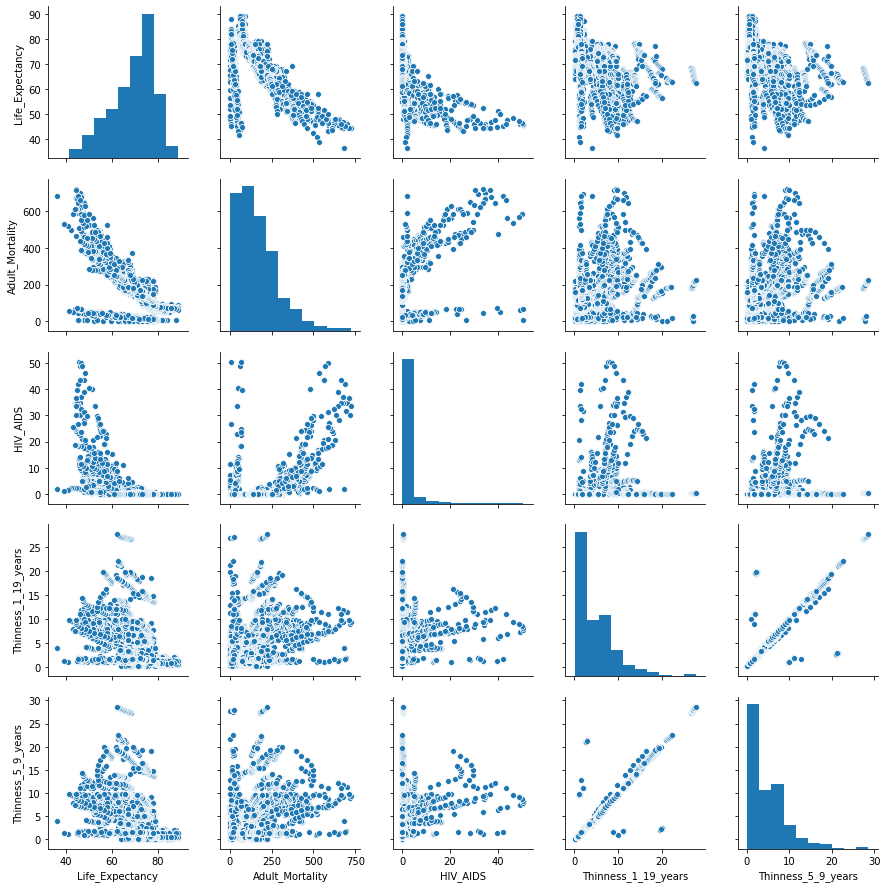

In [22]:
negatively_correlated_cols = [
    'Life_Expectancy',
    'Adult_Mortality',
    'HIV_AIDS',
    'Thinness_1_19_years',
    'Thinness_5_9_years'
]
negatively_correlated_df = df[negatively_correlated_cols]
sns.pairplot(negatively_correlated_df)

`Adult_Mortality` seems most like a linear relationship to me.  Also, the two thinness metrics seem to be providing very similar information, so we almost certainly should not include both

A quick experiment to try to flatten out that curve:

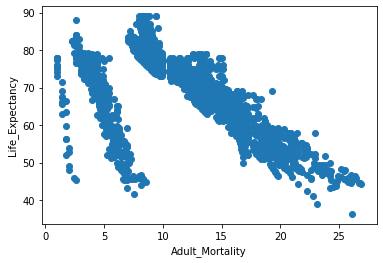

In [23]:
fig3, ax3 = plt.subplots()

ax3.set(xlabel="Adult_Mortality", ylabel="Life_Expectancy")
ax3.scatter(x=np.sqrt(df["Adult_Mortality"]), y=df["Life_Expectancy"])

This gives me straighter lines, but seems to indicate that we probably need at least two separate models to represent this data correctly.  However in the interest of time, I'm just going to assume the relationship is linear.

In [24]:
model_2_df = df[["Life_Expectancy", "Schooling", "Adult_Mortality"]].copy()
model_2_df.dropna(inplace=True)

In [25]:
model_2 = ols(formula="Life_Expectancy ~ Schooling + Adult_Mortality", data=model_2_df).fit()

In [26]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     3443.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:05:15   Log-Likelihood:                -8387.7
No. Observations:                2768   AIC:                         1.678e+04
Df Residuals:                    2765   BIC:                         1.680e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          56.0636      0.475    117.981      0.000      55.132      56.995
Schooling           1.5541      0.032     48.616      0.000       1.491       1.617
Adult_Mortality    -0.0329      0.001    -37.803      0.000      -0.035      -0.031
==============================================================================
Omnibus:                      537.142   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2901.045
Skew:                          -0.813   Prob(JB):                         0.00
Kurtosis:                       7.745   Cond. No.                     1.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Second Model Evaluation

Adding another feature improved the r-squared from 0.565 to 0.714

But let's also look at the model assumptions

#### Linearity

In [27]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_2)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0919639546889197
Rainbow p-value: 0.05102555171520744


Assuming an alpha of 0.05, we are no longer violating the linearity assumption (just barely)

#### Normality

The **Jarque-Bera (JB)** output has gotten worse.  We are still violating the normality assumption.

#### Homoscadasticity

In [28]:
y = model_2_df["Life_Expectancy"]
y_hat = model_2.predict()

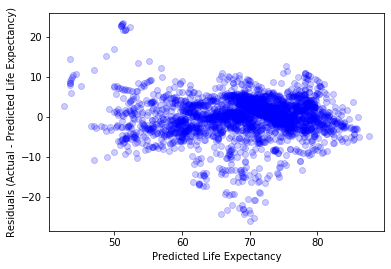

In [29]:
fig4, ax4 = plt.subplots()
ax4.set(xlabel="Predicted Life Expectancy",
        ylabel="Residuals (Actual - Predicted Life Expectancy)")
ax4.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2)

In [30]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model_2_df[["Schooling", "Adult_Mortality"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: 3.8946545111368395e-47
F-statistic p-value: 1.2521305604484036e-47


Both visually and numerically, we can see some improvement.  But we are still violating this assumption to a statistically significant degree.

#### Independence

You might have noticed in the regression output that there was a warning about the condition number being high.  The condition number is a measure of stability of the matrix used for computing the regression (we'll discuss this more in the next module), and a number above 30 can indicate strong multicollinearity.  Our output is way higher than that.

A different (more generous) measure of multicollinearity is the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor).  It is available from the [outlier influence submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html#statsmodels.stats.outliers_influence.variance_inflation_factor).

In [31]:
rows = model_2_df[["Schooling", "Adult_Mortality"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ["Schooling", "Adult_Mortality"]

vif_df

,VIF,feature
0,1.937556,Schooling
1,1.937556,Adult_Mortality


A "rule of thumb" for VIF is that 5 is too high, so I think it's reasonable to say that we are not violating the independence assumption, despite the high condition number.

## Adding a Categorical Value

This is less realistic than the previous steps but I wanted to give an example

In this dataset, we have a lot of numeric values (everything in that correlation matrix), but there are a few that aren't.  One example is `Status`

In [32]:
model_3_df = df[["Life_Expectancy", "Schooling", "Adult_Mortality", "Status"]].copy()
model_3_df.dropna(inplace=True)

In [33]:
model_3_df["Status"].value_counts()

Developing    2304
Developed      464
Name: Status, dtype: int64

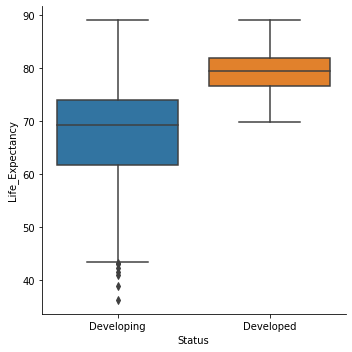

In [35]:
sns.catplot(x="Status", y="Life_Expectancy", data=model_3_df, kind="box");

It looks like there is a difference between the two groups that might be useful to include

There are only two categories, so we only need a `LabelEncoder` that will convert the labels into 1s and 0s.  If there were more than two categories, we would use a `OneHotEncoder`, which would create multiple columns out of a single column.

In [36]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(model_3_df["Status"])
status_labels

array([1, 1, 1, ..., 1, 1, 1])

In [37]:
label_encoder.classes_

array(['Developed', 'Developing'], dtype=object)

This is telling us that "Developed" is encoded as 0 and "Developing" is encoded as 1.  This means that "Developed" is assumed at the intercept.

In [38]:
model_3_df["Status_Encoded"] = status_labels
model_3_df.drop("Status", axis=1)

,Life_Expectancy,Schooling,Adult_Mortality,Status_Encoded
0,65.0,10.1,263.0,1
1,59.9,10.0,271.0,1
2,59.9,9.9,268.0,1
3,59.5,9.8,272.0,1
4,59.2,9.5,275.0,1
...,...,...,...,...
2933,44.3,9.2,723.0,1
2934,44.5,9.5,715.0,1
2935,44.8,10.0,73.0,1
2936,45.3,9.8,686.0,1


In [39]:
model_3 = ols(formula="Life_Expectancy ~ Schooling + Adult_Mortality + Status_Encoded", data=model_3_df).fit()

In [40]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     2350.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:17:15   Log-Likelihood:                -8364.0
No. Observations:                2768   AIC:                         1.674e+04
Df Residuals:                    2764   BIC:                         1.676e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          58.9976      0.634     93.014      0.000      57.754      60.241
Schooling           1.4447      0.035     40.772      0.000       1.375       1.514
Adult_Mortality    -0.0324      0.001    -37.395      0.000      -0.034      -0.031
Status_Encoded     -2.0474      0.296     -6.910      0.000      -2.628      -1.466
==============================================================================
Omnibus:                      570.672   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2798.757
Skew:                          -0.899   Prob(JB):                         0.00
Kurtosis:                       7.586   Cond. No.                     1.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third Model Evaluation

Adding another feature improved the r-squared a tiny bit from 0.714 to 0.718

Let's look at the model assumptions again

#### Linearity

In [41]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0769559317010537
Rainbow p-value: 0.08416346182745868


Another small improvement

#### Normality

The **Jarque-Bera (JB)** output has gotten slightly better.  But we are still violating the normality assumption.

#### Homoscadasticity

In [42]:
y = model_3_df["Life_Expectancy"]
y_hat = model_3.predict()

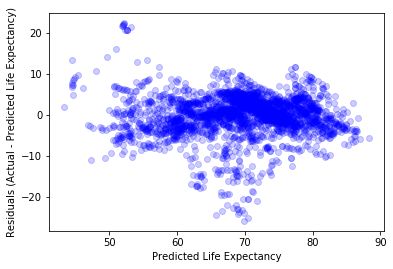

In [44]:
fig5, ax5 = plt.subplots()
ax5.set(xlabel="Predicted Life Expectancy",
        ylabel="Residuals (Actual - Predicted Life Expectancy)")
ax5.scatter(x=y_hat, y=y-y_hat, color="blue", alpha=0.2);

In [45]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model_3_df[["Schooling", "Adult_Mortality", "Status_Encoded"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: 6.82832277846069e-89
F-statistic p-value: 9.27409337812992e-95


This metric got worse, although the plot looks fairly similar

#### Independence

In [46]:
rows = model_3_df[["Schooling", "Adult_Mortality", "Status_Encoded"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(3)]
vif_df["feature"] = ["Schooling", "Adult_Mortality", "Status_Encoded"]

vif_df

,VIF,feature
0,3.120074,Schooling
1,2.838221,Adult_Mortality
2,4.518962,Status_Encoded


The VIF metrics are getting higher, which means that there is stronger multicollinearity.  But we have still not exceeded the threshold of 5.

## Summary

We started with a baseline model where the only input feature was `Schooling`.  Our baseline model had an r-squared of 0.565.  This model violated the linearity (p < 0.001), normality (p < 0.001), and homoscadasticity (p < 0.001) assumptions of linear regression.  The independence assumption was met by default because there was only one input feature.

The final model for this lesson had three input features: `Schooling`, `Adult_Mortality`, and `Status_Encoded`.  It had an r-squared of 0.718.  This model did not violate the linearity assumption (p = 0.084), but it did violate the normality (p < 0.001) and homoscedasticity (p < 0.001) assumptions.  Based on the variance inflaction factor metric, it did not violate the independence assumption.

We are able to address the following questions from above:

*1. Does various predicting factors which has been chosen initially really affect the Life expectancy? What are the predicting variables actually affecting the life expectancy?*

With only 3 features we are able to explain about 71% of the variance in life expectancy.  This indicates that these factors truly are explanatory.  More analysis is required to understand how much additional explanatory power would be provided by incorporating additional features into the model.

*3. How does Infant and Adult mortality rates affect life expectancy?*

So far we have only investigated adult mortality.  The adult mortality rate ("probability of dying between 15 and 60 years per 1000 population") has a negative correlation with life expectancy.  For each increase of 1 in the adult mortality rate, life expectancy decreases by about .03 years.

*5. What is the impact of schooling on the lifespan of humans?*

In our latest model, we find that each additional year of average schooling is associated with 1.4 years of added life expectancy.  However it is challenging to interpret whether it is schooling that is actually having the impact.  Schooling is highly correlated with `Income_Composition_of_Resources` ("Human Development Index in terms of income composition of resources") so it is very possible that schooling is the result of some underlying factor that also impacts life expectancy, rather than schooling impacting life expectancy directly.

### Appendix

Things I have not done in this lesson, but that you should consider in your project:

 - More robust cleaning (possible imputation of missing values, principled exclusion of some data)
 - Feature scaling
 - Nearest-neighbors approach (requires more complex feature engineering)
 - Pulling information from external resources
 - Removing independent variables if you determine that they are causing too high of multicollinearity
 - Setting up functions so the code is not so repetitive
 
Also, I've included a dataset called `cars.csv` if you are interested in additional practice that does not use the King County Housing Data